### Cargar imágenes de monos

Queremos ver por curiosidad como detecta mediapipe los rostros y las manos de los primates.

Las imágenes procesadas se guardarán como resultado en la misma carpeta del cuaderno.

../images/mono_sorprendido.jpg: ✓ Cara detectada


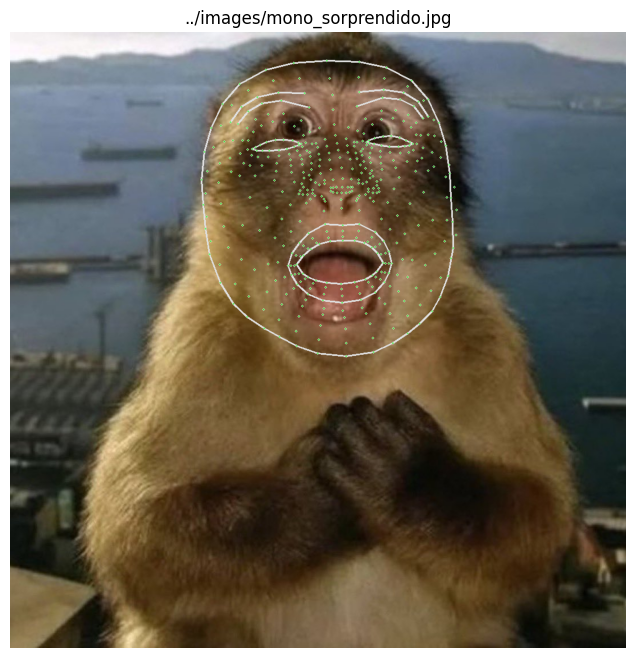

../images/mono_pensando.jpg: ✗ Cara NO detectada


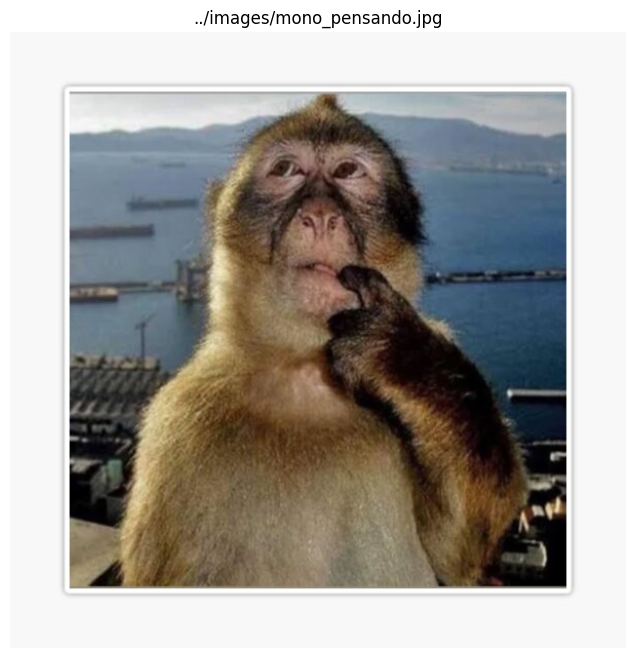

../images/mono_neutral.webp: ✓ Cara detectada


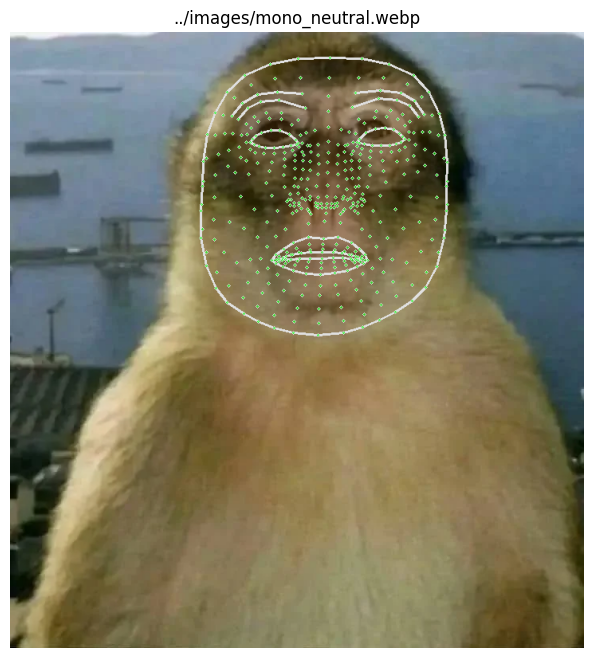

../images/mono_feliz.png: ✓ Cara detectada
../images/mono_feliz.png: ✓ Mano derecha detectada


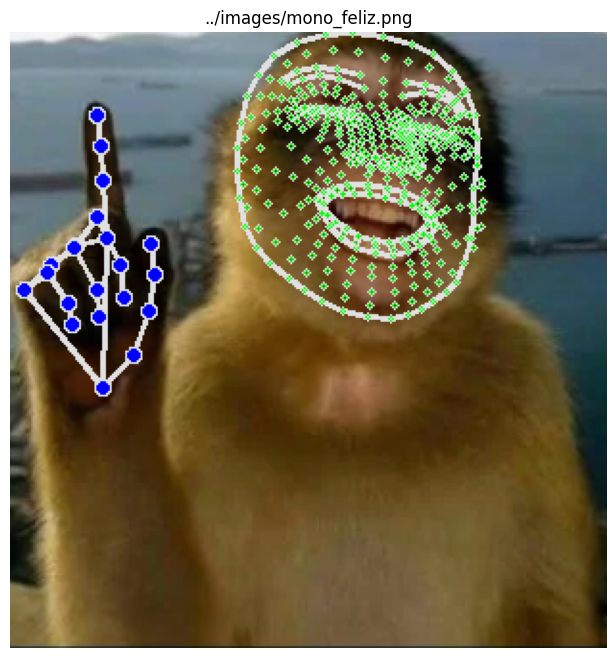

../images/mono_enfadado.jpg: ✗ Cara NO detectada


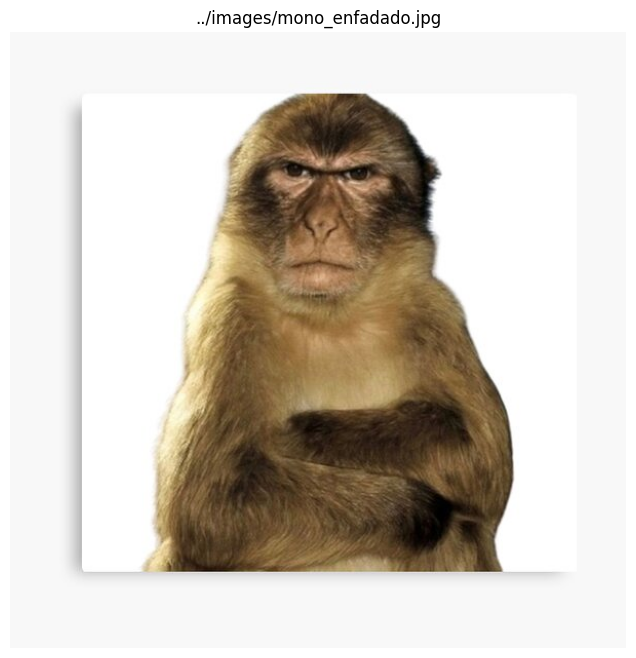

In [1]:
import cv2
import mediapipe as mp
import matplotlib.pyplot as plt

# Inicializar MediaPipe
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils

# Configurar el modelo
holistic = mp_holistic.Holistic(
    static_image_mode=True,  # Para imágenes estáticas
    model_complexity=2,       # 0, 1 o 2 (mayor = más preciso pero más lento)
    min_detection_confidence=0.3,  # Bajado para monos
    min_tracking_confidence=0.3
)

# Lista de archivos
imagenes = [
    '../images/mono_sorprendido.jpg',
    '../images/mono_pensando.jpg',
    '../images/mono_neutral.webp',
    '../images/mono_feliz.png',
    '../images/mono_enfadado.jpg'
]

# Procesar cada imagen
for img_path in imagenes:
    # Leer imagen
    image = cv2.imread(img_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Detectar
    results = holistic.process(image_rgb)
    
    # Dibujar detecciones
    annotated_image = image.copy()
    
    # Cara (468 landmarks)
    if results.face_landmarks:
        mp_drawing.draw_landmarks(
            annotated_image,
            results.face_landmarks,
            mp_holistic.FACEMESH_CONTOURS,
            landmark_drawing_spec=mp_drawing.DrawingSpec(color=(0,255,0), thickness=1, circle_radius=1)
        )
        print(f"{img_path}: ✓ Cara detectada")
    else:
        print(f"{img_path}: ✗ Cara NO detectada")
    
    # Mano derecha (21 landmarks)
    if results.right_hand_landmarks:
        mp_drawing.draw_landmarks(
            annotated_image,
            results.right_hand_landmarks,
            mp_holistic.HAND_CONNECTIONS,
            landmark_drawing_spec=mp_drawing.DrawingSpec(color=(255,0,0), thickness=2, circle_radius=2)
        )
        print(f"{img_path}: ✓ Mano derecha detectada")
    
    # Mano izquierda (21 landmarks)
    if results.left_hand_landmarks:
        mp_drawing.draw_landmarks(
            annotated_image,
            results.left_hand_landmarks,
            mp_holistic.HAND_CONNECTIONS,
            landmark_drawing_spec=mp_drawing.DrawingSpec(color=(0,0,255), thickness=2, circle_radius=2)
        )
        print(f"{img_path}: ✓ Mano izquierda detectada")
    
    # Mostrar resultado
    plt.figure(figsize=(10,8))
    plt.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB))
    plt.title(img_path)
    plt.axis('off')
    plt.show()
    
    # Guardar imagen procesada
    cv2.imwrite(f'detectado_{img_path}', annotated_image)

holistic.close()

### Primera parte de la tarea

Vamos a cargar funciones auxiliares e inicializar mediapipe.

In [2]:
import cv2
import mediapipe as mp
import numpy as np
from collections import deque, Counter

# Inicializar MediaPipe (compartido)
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles

holistic = mp_holistic.Holistic(
    static_image_mode=False,
    model_complexity=1,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5
)

# Cargar imágenes de los monos (compartido)
monos = {
    'neutral': cv2.imread('../images/mono_neutral.webp'),
    'feliz': cv2.imread('../images/mono_feliz.png'),
    'sorprendido': cv2.imread('../images/mono_sorprendido.jpg'),
    'pensando': cv2.imread('../images/mono_pensando.jpg'),
    'enfadado': cv2.imread('../images/mono_enfadado.jpg')
}

# Verificar carga
for nombre, img in monos.items():
    if img is None:
        print(f"No se pudo cargar: {nombre}")

# ========== FUNCIONES COMPARTIDAS ==========

def detectar_dedo_arriba(hand_landmarks):
    """Detecta si el dedo índice está levantado"""
    if hand_landmarks is None:
        return False
    landmarks = hand_landmarks.landmark
    indice_arriba = landmarks[8].y < landmarks[6].y - 0.03
    medio_doblado = landmarks[12].y > landmarks[10].y
    anular_doblado = landmarks[16].y > landmarks[14].y
    menique_doblado = landmarks[20].y > landmarks[18].y
    return indice_arriba and medio_doblado and anular_doblado and menique_doblado

def detectar_indice_en_boca(face_landmarks, hand_landmarks):
    """Detecta si la punta del dedo índice está cerca de la boca"""
    if face_landmarks is None or hand_landmarks is None:
        return False
    boca_x = face_landmarks.landmark[13].x
    boca_y = face_landmarks.landmark[13].y
    indice_punta_x = hand_landmarks.landmark[8].x
    indice_punta_y = hand_landmarks.landmark[8].y
    distancia = np.sqrt((boca_x - indice_punta_x)**2 + (boca_y - indice_punta_y)**2)
    return distancia < 0.08

def detectar_expresion(face_landmarks, hand_landmarks_left, hand_landmarks_right):
    """Detecta expresión facial y gestos de manos"""
    if face_landmarks is None:
        return 'neutral'
    
    landmarks = face_landmarks.landmark
    
    # BOCA
    labio_superior = landmarks[13].y
    labio_inferior = landmarks[14].y
    apertura_boca = abs(labio_inferior - labio_superior)
    
    # SONRISA
    comisura_izq_y = landmarks[61].y
    comisura_der_y = landmarks[291].y
    centro_boca_y = landmarks[13].y
    promedio_comisuras = (comisura_izq_y + comisura_der_y) / 2
    elevacion_sonrisa = centro_boca_y - promedio_comisuras
    
    # CEJAS
    ceja_izq = landmarks[52].y
    ceja_der = landmarks[282].y
    ojo_izq = landmarks[159].y
    ojo_der = landmarks[386].y
    distancia_cejas = ((ojo_izq - ceja_izq) + (ojo_der - ceja_der)) / 2
    
    # GESTOS DE MANOS
    dedo_arriba = (detectar_dedo_arriba(hand_landmarks_right) or 
                   detectar_dedo_arriba(hand_landmarks_left))
    indice_en_boca = (detectar_indice_en_boca(face_landmarks, hand_landmarks_right) or
                      detectar_indice_en_boca(face_landmarks, hand_landmarks_left))
    
    # LÓGICA DE DECISIÓN
    if elevacion_sonrisa > 0.004 and dedo_arriba:
        return 'feliz'
    if indice_en_boca:
        return 'pensando'
    if apertura_boca > 0.05:
        return 'sorprendido'
    if distancia_cejas < 0.025 and elevacion_sonrisa < 0.002:
        return 'enfadado'
    return 'neutral'

def redimensionar_imagen(img, alto_objetivo):
    """Redimensiona imagen manteniendo aspect ratio"""
    if img is None:
        return None
    h, w = img.shape[:2]
    ratio = alto_objetivo / h
    nuevo_ancho = int(w * ratio)
    return cv2.resize(img, (nuevo_ancho, alto_objetivo))

def superponer_mono_en_cara(frame, mono_img, face_landmarks):
    """Superpone la imagen del mono sobre la cara detectada"""
    if face_landmarks is None or mono_img is None:
        return frame
    
    h, w, _ = frame.shape
    landmarks = face_landmarks.landmark
    
    # Obtener bounding box de la cara
    x_coords = [int(landmark.x * w) for landmark in landmarks]
    y_coords = [int(landmark.y * h) for landmark in landmarks]
    
    # Márgenes para hacer el mono más grande
    margen_horizontal = 80
    margen_superior = 120
    margen_inferior = 80
    
    x_min = max(0, min(x_coords) - margen_horizontal)
    x_max = min(w, max(x_coords) + margen_horizontal)
    y_min = max(0, min(y_coords) - margen_superior)
    y_max = min(h, max(y_coords) + margen_inferior)
    
    ancho_cara = x_max - x_min
    alto_cara = y_max - y_min
    
    if ancho_cara <= 0 or alto_cara <= 0:
        return frame
    
    # Redimensionar mono
    mono_resized = cv2.resize(mono_img, (ancho_cara, alto_cara))
    resultado = frame.copy()
    
    # Opacidad alta (más opaco)
    alpha = 0.98
    roi = resultado[y_min:y_max, x_min:x_max]
    
    if roi.shape[:2] == mono_resized.shape[:2]:
        resultado[y_min:y_max, x_min:x_max] = cv2.addWeighted(
            roi, 1 - alpha, mono_resized, alpha, 0
        )
    
    return resultado

print("Funciones cargadas correctamente")


Funciones cargadas correctamente


### Primera demo (monos)

Hacemos una pequeña demo con nuestra camara a un lado y la imagen que detecta al otro lado para ver si está bien lo que detectamos.

In [18]:
# Iniciar webcam
cap = cv2.VideoCapture(0)

if not cap.isOpened():
    print("Error: No se pudo abrir la webcam")
else:
    print("Webcam iniciada - Modo LADO A LADO")
    print("Gestos:")
    print("  FELIZ: Sonríe + levanta el dedo índice")
    print("  PENSANDO: Pon el dedo índice en la boca")
    print("  SORPRENDIDO: Abre mucho la boca")
    print("  ENFADADO: Frunce el ceño")
    print("  NEUTRAL: Cara relajada")
    print("\nPresiona 'q' para salir")

historial = deque(maxlen=3)

while True:
    ret, frame = cap.read()
    if not ret:
        break
    
    frame = cv2.flip(frame, 1)
    image_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = holistic.process(image_rgb)
    
    annotated_frame = frame.copy()
    
    # Dibujar landmarks faciales
    if results.face_landmarks:
        mp_drawing.draw_landmarks(
            annotated_frame,
            results.face_landmarks,
            mp_holistic.FACEMESH_CONTOURS,
            landmark_drawing_spec=None,
            connection_drawing_spec=mp_drawing_styles.get_default_face_mesh_contours_style()
        )
    
    # Dibujar landmarks de manos
    if results.right_hand_landmarks:
        mp_drawing.draw_landmarks(
            annotated_frame,
            results.right_hand_landmarks,
            mp_holistic.HAND_CONNECTIONS,
            mp_drawing_styles.get_default_hand_landmarks_style(),
            mp_drawing_styles.get_default_hand_connections_style()
        )
    
    if results.left_hand_landmarks:
        mp_drawing.draw_landmarks(
            annotated_frame,
            results.left_hand_landmarks,
            mp_holistic.HAND_CONNECTIONS,
            mp_drawing_styles.get_default_hand_landmarks_style(),
            mp_drawing_styles.get_default_hand_connections_style()
        )
    
    # Detectar expresión
    estado = detectar_expresion(
        results.face_landmarks,
        results.left_hand_landmarks,
        results.right_hand_landmarks
    )
    
    # Suavizado temporal
    historial.append(estado)
    estado_actual = Counter(historial).most_common(1)[0][0]
    
    # Obtener mono y redimensionar
    mono_img = monos.get(estado_actual, monos['neutral'])
    altura_frame = annotated_frame.shape[0]
    mono_resized = redimensionar_imagen(mono_img, altura_frame)
    
    if mono_resized is not None:
        # Texto con estado
        cv2.putText(annotated_frame, f"Estado: {estado_actual.upper()}", 
                    (10, 40), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 0, 0), 3)
        
        # Combinar lado a lado
        combined = np.hstack((annotated_frame, mono_resized))
    else:
        combined = annotated_frame
    
    cv2.imshow('Espejo con el mono', combined)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()
print("Finalizado")


Webcam iniciada - Modo LADO A LADO
Gestos:
  FELIZ: Sonríe + levanta el dedo índice
  PENSANDO: Pon el dedo índice en la boca
  SORPRENDIDO: Abre mucho la boca
  ENFADADO: Frunce el ceño
  NEUTRAL: Cara relajada

Presiona 'q' para salir
Finalizado


### Segunda demo (monos)

Demo donde se superpone la imagen del mono sobre nosotros. Cambiando la imagen según lo que hagamos.

In [19]:
# Iniciar webcam
cap = cv2.VideoCapture(0)

if not cap.isOpened():
    print("Error: No se pudo abrir la webcam")
else:
    print("Webcam iniciada - Modo SUPERPOSICIÓN")
    print("Gestos:")
    print("  FELIZ: Sonríe + levanta el dedo índice")
    print("  PENSANDO: Pon el dedo índice en la boca")
    print("  SORPRENDIDO: Abre mucho la boca")
    print("  ENFADADO: Frunce el ceño")
    print("  NEUTRAL: Cara relajada")
    print("\nPresiona 'q' para salir")

historial = deque(maxlen=3)

while True:
    ret, frame = cap.read()
    if not ret:
        break
    
    frame = cv2.flip(frame, 1)
    image_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = holistic.process(image_rgb)
    
    # Detectar expresión
    estado = detectar_expresion(
        results.face_landmarks,
        results.left_hand_landmarks,
        results.right_hand_landmarks
    )
    
    # Suavizado temporal
    historial.append(estado)
    estado_actual = Counter(historial).most_common(1)[0][0]
    
    # Obtener imagen del mono
    mono_img = monos.get(estado_actual, monos['neutral'])
    
    # Superponer mono sobre la cara
    frame_con_mono = superponer_mono_en_cara(frame, mono_img, results.face_landmarks)
    
    # Añadir texto con el estado
    cv2.putText(frame_con_mono, f"Estado: {estado_actual.upper()}", 
                (10, 40), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 0, 0), 3)
    
    cv2.imshow('Mono encima de la cara', frame_con_mono)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()
print("Finalizado")


Webcam iniciada - Modo SUPERPOSICIÓN
Gestos:
  FELIZ: Sonríe + levanta el dedo índice
  PENSANDO: Pon el dedo índice en la boca
  SORPRENDIDO: Abre mucho la boca
  ENFADADO: Frunce el ceño
  NEUTRAL: Cara relajada

Presiona 'q' para salir
Finalizado


### Segundo filtro

Por miedo de que lo de los monos no sea suficiente hemos desarrollado otro filtro donde ponemos una orejas y nariz de koala al usuario con la capacidad de ponerse o quitarse unas gafas de sol cuando el quiera.

Definimos imports y funciones auxiliares.

In [5]:
import cv2
import mediapipe as mp
import numpy as np

# Inicializar MediaPipe FaceMesh
mp_face_mesh = mp.solutions.face_mesh

face_mesh = mp_face_mesh.FaceMesh(
    max_num_faces=1,
    refine_landmarks=True,
    min_detection_confidence=0.6,
    min_tracking_confidence=0.6
)

print("MediaPipe inicializado")


def eliminar_fondo_claro(img):
    """Funcion basica para eliminar fondo blanco/gris"""
    if img is None:
        return None
    
    if len(img.shape) == 3 and img.shape[2] == 4:
        return img
    
    img_alpha = cv2.cvtColor(img, cv2.COLOR_BGR2BGRA)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, mask = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY)
    mask_inv = cv2.bitwise_not(mask)
    img_alpha[:, :, 3] = mask_inv
    
    return img_alpha

def eliminar_fondo_gafas(img):
    """Funcion especial para eliminar fondo de gafas (incluye sombras)"""
    if img is None:
        return None
    
    if len(img.shape) == 3 and img.shape[2] == 4:
        img_bgr = img[:, :, :3]
    else:
        img_bgr = img
    
    img_alpha = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2BGRA)
    hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)
    
    lower = np.array([0, 0, 150])
    upper = np.array([180, 60, 255])
    
    mask_white = cv2.inRange(hsv, lower, upper)
    
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    _, mask_bright = cv2.threshold(gray, 170, 255, cv2.THRESH_BINARY)
    
    mask_combined = cv2.bitwise_or(mask_white, mask_bright)
    
    kernel = np.ones((3, 3), np.uint8)
    mask_combined = cv2.morphologyEx(mask_combined, cv2.MORPH_OPEN, kernel, iterations=1)
    mask_combined = cv2.morphologyEx(mask_combined, cv2.MORPH_CLOSE, kernel, iterations=1)
    
    mask_inv = cv2.bitwise_not(mask_combined)
    img_alpha[:, :, 3] = mask_inv
    
    return img_alpha

print("Funciones de procesamiento cargadas")


MediaPipe inicializado
Funciones de procesamiento cargadas


### Cargamos las imágenes

In [7]:
# Cargar koala
filtro_koala = cv2.imread('../images/cara-koala.jpg')
if filtro_koala is None:
    print("Error: no se pudo cargar cara-koala.jpg")
else:
    filtro_koala = eliminar_fondo_claro(filtro_koala)
    print("Filtro koala cargado")

# Cargar gafas
gafas_sol = cv2.imread('../images/gafas.png', cv2.IMREAD_UNCHANGED)
if gafas_sol is None:
    print("Advertencia: no se pudo cargar gafas.png")
    gafas_sol = None
else:
    gafas_sol = eliminar_fondo_gafas(gafas_sol)
    print("Gafas cargadas")

# Estado inicial
gafas_activas = False
print("Filtros cargados correctamente")

Filtro koala cargado
Gafas cargadas
Filtros cargados correctamente


### Funciones de transformaciones geométricas

In [8]:
def calcular_angulo_inclinacion(face_landmarks, w, h):
    """Calcula el angulo de inclinacion de la cabeza"""
    landmarks = face_landmarks.landmark
    
    ojo_izq = landmarks[33]
    ojo_der = landmarks[263]
    
    ojo_izq_x = int(ojo_izq.x * w)
    ojo_izq_y = int(ojo_izq.y * h)
    ojo_der_x = int(ojo_der.x * w)
    ojo_der_y = int(ojo_der.y * h)
    
    delta_y = ojo_der_y - ojo_izq_y
    delta_x = ojo_der_x - ojo_izq_x
    
    angulo = -np.degrees(np.arctan2(delta_y, delta_x))
    
    return angulo, (ojo_izq_x, ojo_izq_y), (ojo_der_x, ojo_der_y)

def rotar_imagen_con_alpha(img, angulo):
    """Rota una imagen manteniendo el canal alpha"""
    if img is None:
        return None
    
    h, w = img.shape[:2]
    centro = (w // 2, h // 2)
    
    matriz = cv2.getRotationMatrix2D(centro, angulo, 1.0)
    
    cos = np.abs(matriz[0, 0])
    sin = np.abs(matriz[0, 1])
    
    nuevo_w = int((h * sin) + (w * cos))
    nuevo_h = int((h * cos) + (w * sin))
    
    matriz[0, 2] += (nuevo_w / 2) - centro[0]
    matriz[1, 2] += (nuevo_h / 2) - centro[1]
    
    rotada = cv2.warpAffine(img, matriz, (nuevo_w, nuevo_h), 
                            flags=cv2.INTER_LINEAR,
                            borderMode=cv2.BORDER_CONSTANT,
                            borderValue=(0, 0, 0, 0))
    
    return rotada

def superponer_con_transparencia(frame, overlay, x, y, ancho, alto):
    """Superpone una imagen con canal alpha sobre el frame"""
    if overlay is None:
        return frame
    
    try:
        overlay_resized = cv2.resize(overlay, (ancho, alto))
    except:
        return frame
    
    h, w = frame.shape[:2]
    overlay_h, overlay_w = overlay_resized.shape[:2]
    
    x = int(max(0, min(x, w - overlay_w)))
    y = int(max(0, min(y, h - overlay_h)))
    
    x_end = int(min(x + overlay_w, w))
    y_end = int(min(y + overlay_h, h))
    
    overlay_w_actual = x_end - x
    overlay_h_actual = y_end - y
    
    if overlay_w_actual <= 0 or overlay_h_actual <= 0:
        return frame
    
    overlay_crop = overlay_resized[:overlay_h_actual, :overlay_w_actual]
    roi = frame[y:y_end, x:x_end]
    
    if roi.shape[:2] != overlay_crop.shape[:2]:
        return frame
    
    if overlay_crop.shape[2] == 4:
        overlay_bgr = overlay_crop[:, :, :3]
        alpha = overlay_crop[:, :, 3] / 255.0
        alpha_3channel = np.zeros_like(roi, dtype=np.float32)
        alpha_3channel[:, :, 0] = alpha
        alpha_3channel[:, :, 1] = alpha
        alpha_3channel[:, :, 2] = alpha
        resultado = (overlay_bgr * alpha_3channel + roi * (1 - alpha_3channel)).astype(np.uint8)
        frame[y:y_end, x:x_end] = resultado
    else:
        frame[y:y_end, x:x_end] = overlay_crop
    
    return frame

print("Funciones de transformacion cargadas")


Funciones de transformacion cargadas


### Funciones para aplicar filtros

In [9]:
def aplicar_filtro_koala_con_rotacion(frame, face_landmarks, filtro_img, debug_mode=False):
    """Aplica el filtro de koala sobre la cara detectada"""
    if face_landmarks is None or filtro_img is None:
        return frame
    
    h, w, _ = frame.shape
    landmarks = face_landmarks.landmark
    
    angulo, ojo_izq_coord, ojo_der_coord = calcular_angulo_inclinacion(face_landmarks, w, h)
    
    filtro_rotado = rotar_imagen_con_alpha(filtro_img, angulo)
    
    if filtro_rotado is None:
        return frame
    
    nariz = landmarks[1]
    top_cabeza = landmarks[10]
    mejilla_izq = landmarks[234]
    mejilla_der = landmarks[454]
    barbilla = landmarks[152]
    
    nariz_x = int(nariz.x * w)
    nariz_y = int(nariz.y * h)
    
    top_y = int(top_cabeza.y * h)
    barbilla_y = int(barbilla.y * h)
    
    mejilla_izq_x = int(mejilla_izq.x * w)
    mejilla_der_x = int(mejilla_der.x * w)
    
    ancho_cara = abs(mejilla_der_x - mejilla_izq_x)
    alto_cara_real = abs(barbilla_y - top_y)
    
    ancho_filtro = int(ancho_cara * 2.4)
    alto_filtro = int(alto_cara_real * 2.1)
    
    x_filtro = nariz_x - ancho_filtro // 2
    
    y_nariz_en_filtro = int(alto_filtro * 0.55)
    y_filtro = nariz_y - y_nariz_en_filtro
    
    if debug_mode:
        cv2.line(frame, ojo_izq_coord, ojo_der_coord, (255, 0, 255), 2)
        cv2.circle(frame, (nariz_x, nariz_y), 8, (0, 0, 255), -1)
        cv2.putText(frame, f"Angulo: {angulo:.1f}", 
                   (10, 110), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 0), 2)
        cv2.rectangle(frame, (x_filtro, y_filtro), 
                     (x_filtro + ancho_filtro, y_filtro + alto_filtro), (0, 255, 255), 2)
    
    frame = superponer_con_transparencia(frame, filtro_rotado, 
                                         x_filtro, y_filtro, 
                                         ancho_filtro, alto_filtro)
    
    return frame

print("Funcion de filtro koala cargada")


def aplicar_gafas_sol(frame, face_landmarks, gafas_img, angulo, debug_mode=False):
    """Aplica las gafas de sol sobre los ojos"""
    if face_landmarks is None or gafas_img is None:
        return frame
    
    h, w, _ = frame.shape
    landmarks = face_landmarks.landmark
    
    gafas_rotadas = rotar_imagen_con_alpha(gafas_img, angulo)
    
    if gafas_rotadas is None:
        return frame
    
    gafas_h, gafas_w = gafas_rotadas.shape[:2]
    proporcion_gafas = gafas_w / gafas_h
    
    ojo_izq = landmarks[33]
    ojo_der = landmarks[263]
    
    ojo_izq_x = int(ojo_izq.x * w)
    ojo_izq_y = int(ojo_izq.y * h)
    ojo_der_x = int(ojo_der.x * w)
    ojo_der_y = int(ojo_der.y * h)
    
    centro_x = (ojo_izq_x + ojo_der_x) // 2
    centro_y = (ojo_izq_y + ojo_der_y) // 2
    
    distancia_ojos = abs(ojo_der_x - ojo_izq_x)
    ancho_gafas = int(distancia_ojos * 2.0)
    
    alto_gafas = int(ancho_gafas / proporcion_gafas)
    
    x_gafas = centro_x - ancho_gafas // 2
    y_gafas = centro_y - alto_gafas // 2
    
    if debug_mode:
        cv2.circle(frame, (ojo_izq_x, ojo_izq_y), 5, (255, 0, 0), -1)
        cv2.circle(frame, (ojo_der_x, ojo_der_y), 5, (255, 0, 0), -1)
        cv2.circle(frame, (centro_x, centro_y), 5, (0, 255, 0), -1)
        cv2.rectangle(frame, (x_gafas, y_gafas), 
                     (x_gafas + ancho_gafas, y_gafas + alto_gafas), (255, 255, 0), 2)
    
    frame = superponer_con_transparencia(frame, gafas_rotadas, 
                                         x_gafas, y_gafas, 
                                         ancho_gafas, alto_gafas)
    
    return frame

print("Funcion de gafas cargada")



Funcion de filtro koala cargada
Funcion de gafas cargada


### Demo final

In [21]:
cap = cv2.VideoCapture(0)
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 1280)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 720)

if not cap.isOpened():
    print("Error: no se pudo abrir la webcam")
else:
    print("Webcam iniciada")
    print("1: activar/desactivar gafas")
    print("D: debug")
    print("Q: salir")

debug_mode = False

try:
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        frame = cv2.flip(frame, 1)
        image_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        results = face_mesh.process(image_rgb)
        
        if results.multi_face_landmarks:
            face_landmarks = results.multi_face_landmarks[0]
            
            h, w, _ = frame.shape
            angulo, _, _ = calcular_angulo_inclinacion(face_landmarks, w, h)
            
            frame_con_filtro = aplicar_filtro_koala_con_rotacion(frame, face_landmarks, filtro_koala, debug_mode)
            
            if gafas_activas and gafas_sol is not None:
                frame_con_filtro = aplicar_gafas_sol(frame_con_filtro, face_landmarks, gafas_sol, angulo, debug_mode)
            
        else:
            frame_con_filtro = frame
            cv2.putText(frame_con_filtro, "No se detecta cara", 
                        (10, 80), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
        
        texto = "Filtro: koala"
        if gafas_activas:
            texto += " + gafas"
        if debug_mode:
            texto += " [debug]"
        
        cv2.putText(frame_con_filtro, texto, 
                    (10, 40), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 255, 0), 3)
        cv2.putText(frame_con_filtro, "1:gafas D:debug Q:salir", 
                    (10, frame.shape[0] - 20), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
        
        cv2.imshow('Filtro koala + gafas', frame_con_filtro)
        
        key = cv2.waitKey(1) & 0xFF
        
        if key == ord('q'):
            break
        elif key == ord('1'):
            gafas_activas = not gafas_activas
            estado = "activadas" if gafas_activas else "desactivadas"
            print(f"Gafas: {estado}")
        elif key == ord('d'):
            debug_mode = not debug_mode
            print(f"Debug: {'on' if debug_mode else 'off'}")

except KeyboardInterrupt:
    print("Interrumpido por usuario")

finally:
    cap.release()
    cv2.destroyAllWindows()
    print("Webcam cerrada")

Webcam iniciada
1: activar/desactivar gafas
D: debug
Q: salir
Gafas: desactivadas
Gafas: activadas
Gafas: desactivadas
Gafas: activadas
Gafas: desactivadas
Gafas: activadas
Gafas: desactivadas
Gafas: activadas
Gafas: desactivadas
Gafas: activadas
Gafas: desactivadas
Gafas: activadas
Gafas: desactivadas
Gafas: activadas
Gafas: desactivadas
Gafas: activadas
Gafas: desactivadas
Gafas: activadas
Gafas: desactivadas
Gafas: activadas
Webcam cerrada


### Si quieres volver a ejecutar la demo final ejecuta este bloque antes 

In [20]:
# Inicializar MediaPipe FaceMesh
mp_face_mesh = mp.solutions.face_mesh

face_mesh = mp_face_mesh.FaceMesh(
    max_num_faces=1,
    refine_landmarks=True,
    min_detection_confidence=0.6,
    min_tracking_confidence=0.6
)

print("MediaPipe inicializado")

MediaPipe inicializado
